In [16]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets

import helper
import numpy as np

In [17]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the training data
train_set = datasets.ImageFolder('out/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Load the validation data
validation_set = datasets.ImageFolder('out/validation/', transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

# Load the test data
test_set = datasets.ImageFolder('out/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [18]:
# Create model
model = nn.Sequential(nn.Linear(784, 256),
                     nn.Dropout(p=0.2),
                     nn.ReLU(),
                     nn.Linear(256, 128),
                     nn.Dropout(p=0.2),
                     nn.ReLU(),
                     nn.Linear(128, 64),
                     nn.Dropout(p=0.2),
                     nn.ReLU(),
                     nn.Linear(64, 10),
                     nn.Dropout(p=0.2),
                     nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.03)

In [19]:
epochs = 30
steps = 0

train_losses, validation_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten images
        images = images.view(images.shape[0], -1)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()

        # Forwards pass, then backward pass, then update weights
        propabilities = model(images)
        loss = criterion(propabilities, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        validation_loss = 0
        min_validaiton_loss = 1000
        accuracy = 0
        
        # Turn off gradients for testing
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            for images, labels in validation_loader:
                # Flatten images
                images = images.view(images.shape[0], -1)
                
                propabilities = model(images)
                validation_loss += criterion(propabilities, labels)
                
                # Get the class propabilities
                ps = torch.exp(propabilities)
                
                # Get top propability
                top_propability, top_class = ps.topk(1, dim=1)
                
                # Comparing one element in each row of top_class with 
                # each of the labels, and return True/False
                equals = top_class == labels.view(*top_class.shape) 
                
                # Number of correct predictions
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        # Set model to train mode
        model.train()
        
        train_losses.append(running_loss/len(train_loader))
        validation_losses.append(validation_loss/len(validation_loader))
        
        # Get minimum validation loss
        min_validaiton_loss = min(validation_losses)
        
        # Counting the losses
        training_loss = running_loss/len(validation_loader)
        validation_loss = validation_loss/len(validation_loader)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(training_loss),
              "Validation Loss: {:.3f}.. ".format(validation_loss),
              "Validation Accuracy: {:.3f}%".format((accuracy/len(validation_loader))*100))
        
        # Save model if validation loss have decreased
        if validation_loss <= min_validaiton_loss:
            print("Validation has decreased, saving model")
            torch.save(model.state_dict(), 'model.pt')
            min_validaiton_loss = validation_loss

Epoch: 1/30..  Training Loss: 8.922..  Validation Loss: 2.243..  Validation Accuracy: 27.734%
Validation has decreased, saving model
Epoch: 2/30..  Training Loss: 8.485..  Validation Loss: 2.015..  Validation Accuracy: 30.371%
Validation has decreased, saving model
Epoch: 3/30..  Training Loss: 7.795..  Validation Loss: 1.818..  Validation Accuracy: 39.062%
Validation has decreased, saving model
Epoch: 4/30..  Training Loss: 7.330..  Validation Loss: 1.711..  Validation Accuracy: 41.357%
Validation has decreased, saving model
Epoch: 5/30..  Training Loss: 7.103..  Validation Loss: 1.661..  Validation Accuracy: 44.043%
Validation has decreased, saving model
Epoch: 6/30..  Training Loss: 6.922..  Validation Loss: 1.645..  Validation Accuracy: 43.701%
Validation has decreased, saving model
Epoch: 7/30..  Training Loss: 6.807..  Validation Loss: 1.571..  Validation Accuracy: 47.949%
Validation has decreased, saving model
Epoch: 8/30..  Training Loss: 6.628..  Validation Loss: 1.549..  Vali

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

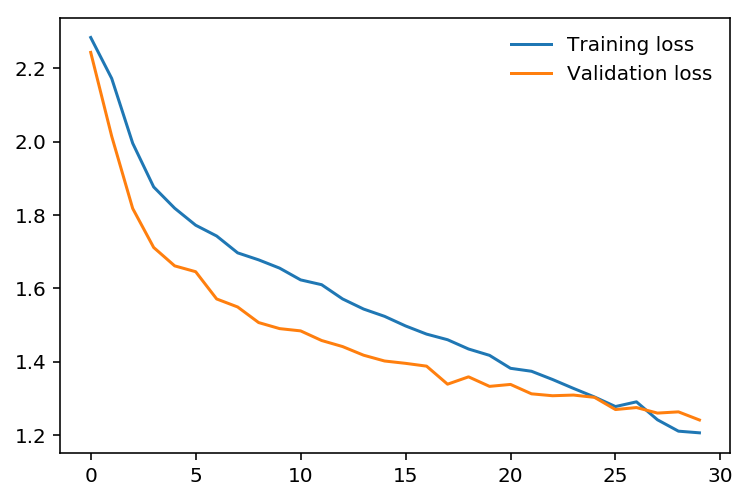

In [21]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False)

Test Accuracy: 60.082%


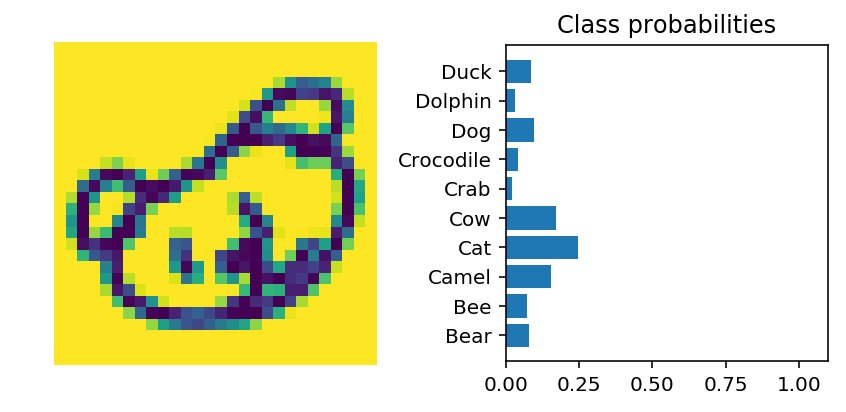

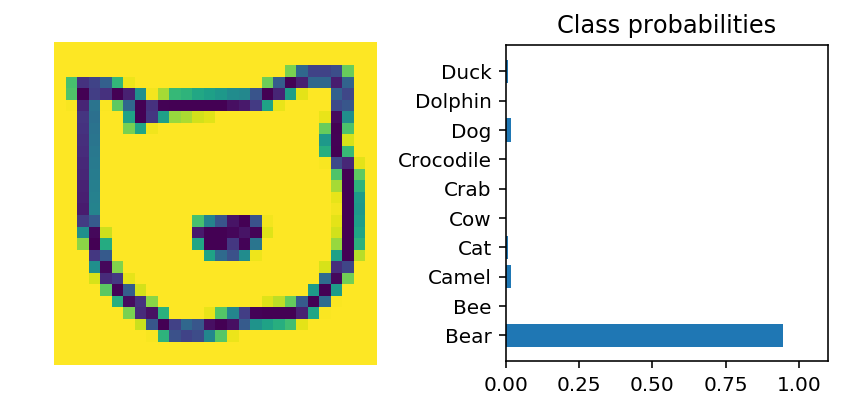

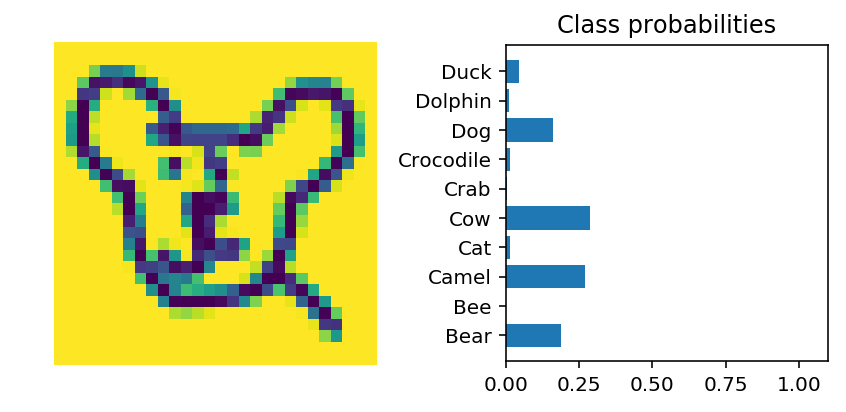

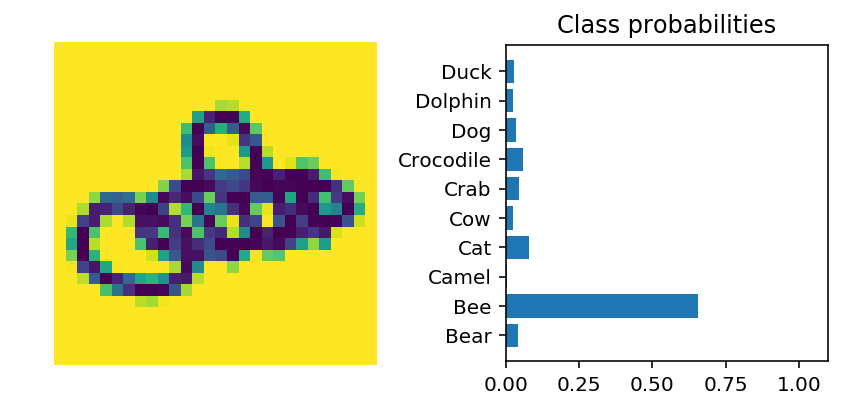

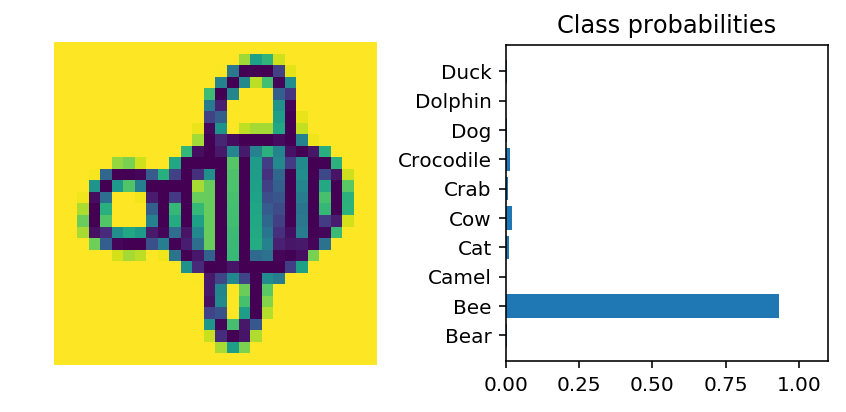

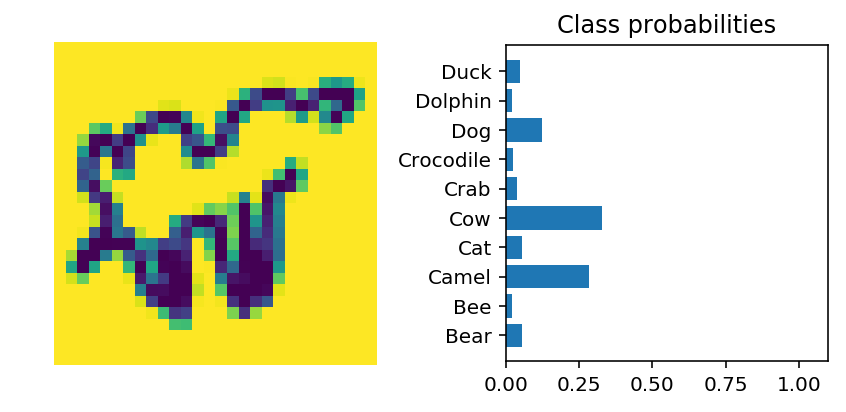

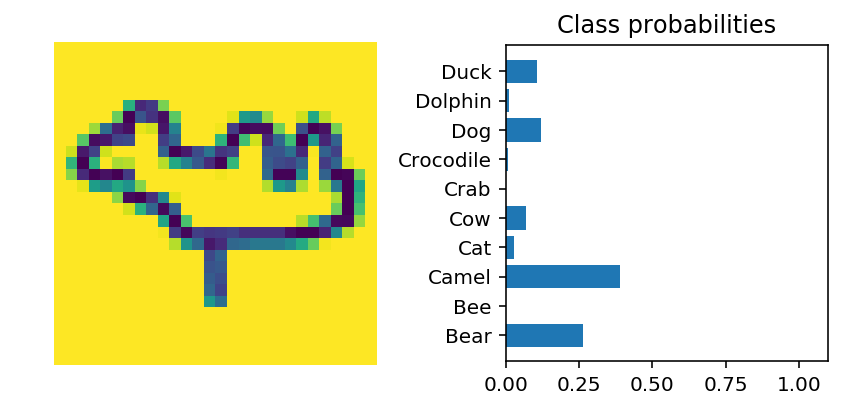

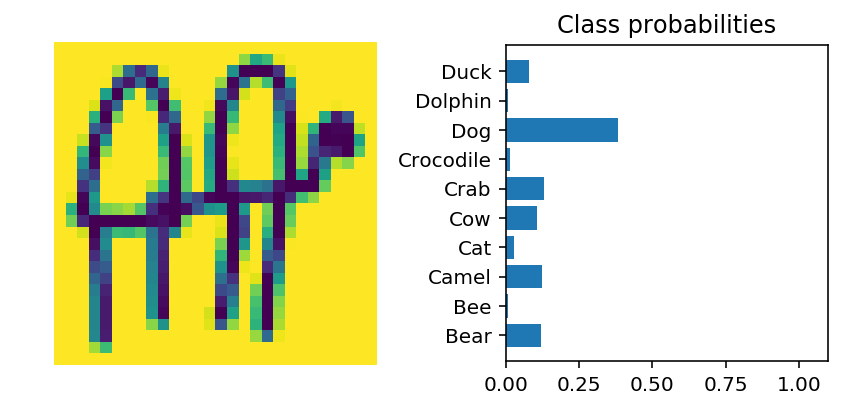

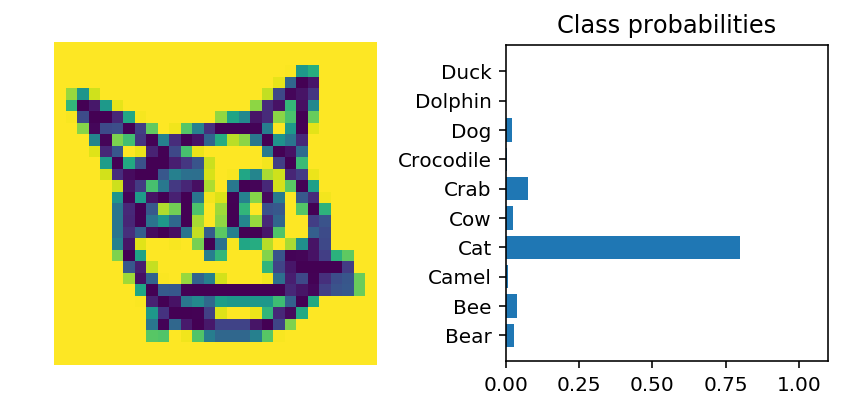

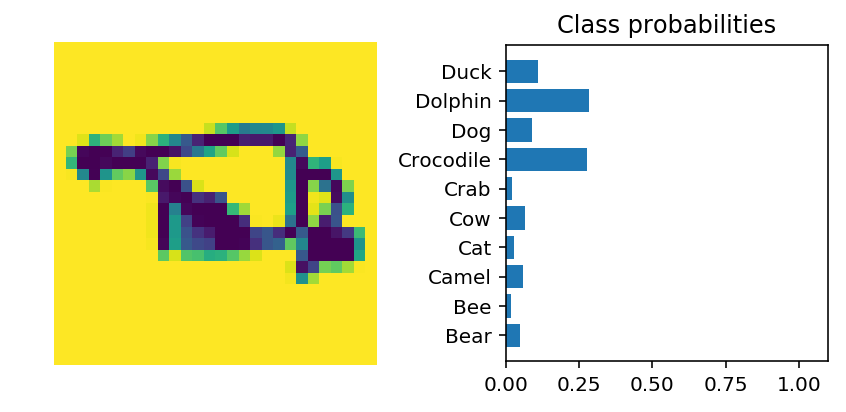

In [22]:
# Prepare model for evaluation
model.eval()

classification_result_counter = 0
test_accuracy = 0

for images, labels in test_loader:
    # Flatten images
    images = images.view(images.shape[0], -1)
    propabilities = model(images)

    # Get the class propabilities
    ps = torch.exp(propabilities)

    # Get top propability
    top_propability, top_class = ps.topk(1, dim=1)

    # Comparing one element in each row of top_class with 
    # each of the labels, and return True/False
    equals = top_class == labels.view(*top_class.shape)

    # Number of correct predictions
    test_accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    # Plot the image and probabilities
    if (classification_result_counter <= 9):
        helper.view_classification_result(images[0].view(1, 28, 28), ps[0])
        classification_result_counter += 1
            
print("Test Accuracy: {:.3f}%".format((test_accuracy/len(test_loader))*100))
